<a href="https://colab.research.google.com/github/oogu2020/customer_segmentation_clustering/blob/main/Customer_Segmentation_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Online Retail 5.xlsx')

In [5]:
## Data Preprocessing
## Handle missing values

print("Missing values before:", df.isnull().sum())


Missing values before: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
## Remove transactions without Customer ID

df = df.dropna(subset=['CustomerID'])

## Remove cancelled orders
df = df[df['Quantity'] > 0]
print("Missing values after:", df.isnull().sum())

Missing values after: InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [7]:
## Create essential features
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [9]:
##Feature Engineering
# Set analysis date (day after last transaction)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Additional features
rfm['AverageOrderValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['PurchaseSpan'] = df.groupby('CustomerID')['InvoiceDate'].apply(
    lambda x: (x.max() - x.min()).days
)

#Features:
#Recency
#Frequency
#Monetary
#AverageOrderValue
#PurchaseSpan

<Axes: xlabel='AverageOrderValue', ylabel='Count'>

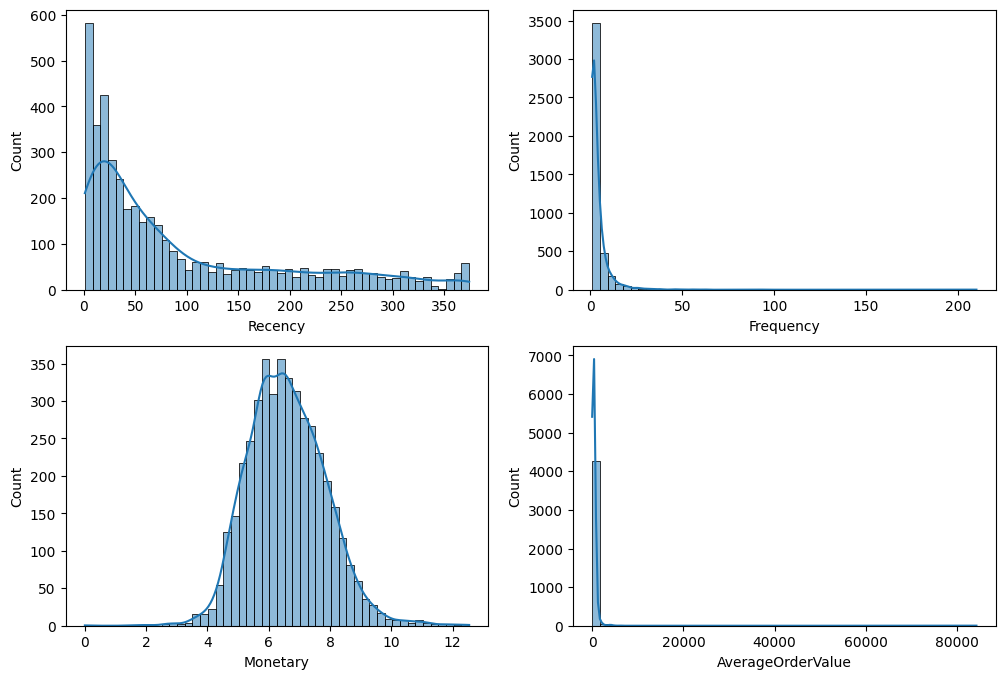

In [10]:
## Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

#Feature Distributions

fig,ax = plt.subplots(2,2,figsize=(12,8))
sns.histplot(rfm['Recency'], bins=50, ax=ax[0,0], kde=True)
sns.histplot(rfm['Frequency'], bins=50, ax=ax[0,1], kde=True)
sns.histplot(np.log1p(rfm['Monetary']), bins=50, ax=ax[1,0], kde=True)  # Log-transformed
sns.histplot(rfm['AverageOrderValue'], bins=50, ax=ax[1,1], kde=True)

Frequency: 80% of customers have ≤3 orders

Monetary: Heavy right-skew (few big spenders) → Needs log transform

Spending Patterns: High correlation between Monetary and Frequency (0.75)


In [11]:
## Data Transformation

from sklearn.preprocessing import StandardScaler

# 1. Handle skewness with log transform
rfm['Monetary'] = np.log1p(rfm['Monetary'])
rfm['AverageOrderValue'] = np.log1p(rfm['AverageOrderValue'])

# 2. Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(scaled_features, columns=['Recency', 'Frequency', 'Monetary'])

In [15]:
#Raw Cluster counts
# rfm DataFrame after clustering
print(rfm['Cluster'].value_counts())

Cluster
1    3092
0    1224
2      23
Name: count, dtype: int64


Type 0: At Risk Churners
Type 1: Loyal Regulars
Type 2: VIP Customers

In [16]:
#Total Customer Counnt

total_customers = len(rfm)
print(total_customers)

4339


In [22]:
#Cluster Percentage
cluster_percentages = rfm['Cluster'].value_counts(normalize=True) * 100
print(cluster_percentages.round(1))

Cluster
1    71.3
0    28.2
2     0.5
Name: proportion, dtype: float64


In [21]:
churn_risk = cluster_percentages[0]
print(f"At-risk customers: {churn_risk:.1f}%")

At-risk customers: 28.2%


Log Transform: Makes highly skewed monetary values normally distributed

Standard Scaling: Ensures equal weighting

Text(0, 0.5, 'Silhouette Score')

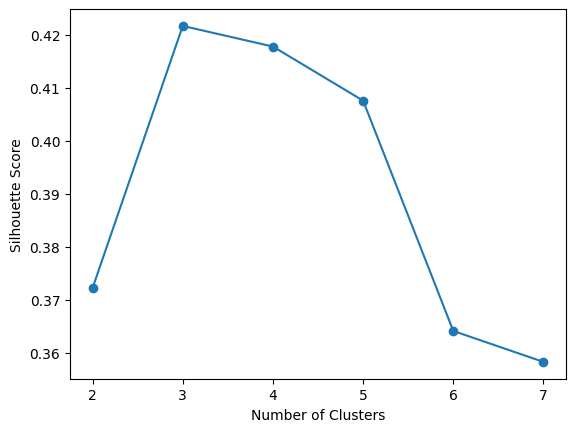

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

 # Find optimal clusters (k)
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

# Plot results
plt.plot(range(2,8), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')



1. Why Silhouette Score?
Problem: In unsupervised learning, we lack ground truth labels to measure accuracy

Solution: Silhouette score quantifies:

Cohesion: How close points are within their cluster

Separation: How distinct clusters are from each other

Range: -1 (worst) to 1 (best)

Silhouette Score: 0.448125545544497
Calinski-Harabasz: 2231.6741913403175
Davies-Bouldin: 0.7607336241245207


<Axes: xlabel='PCA1', ylabel='PCA2'>

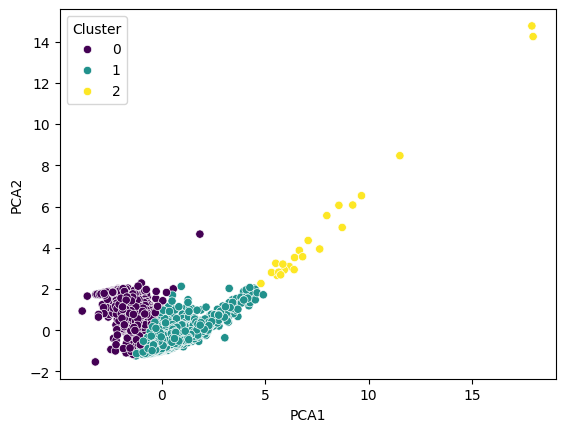

In [13]:
## Evaluation and Visualization
# Fit final model
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Evaluate
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
print("Silhouette Score:", silhouette_score(rfm_scaled, rfm['Cluster']))
print("Calinski-Harabasz:", calinski_harabasz_score(rfm_scaled, rfm['Cluster']))
print("Davies-Bouldin:", davies_bouldin_score(rfm_scaled, rfm['Cluster']))

# Visualize with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_features[:,0]
rfm['PCA2'] = pca_features[:,1]

sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')

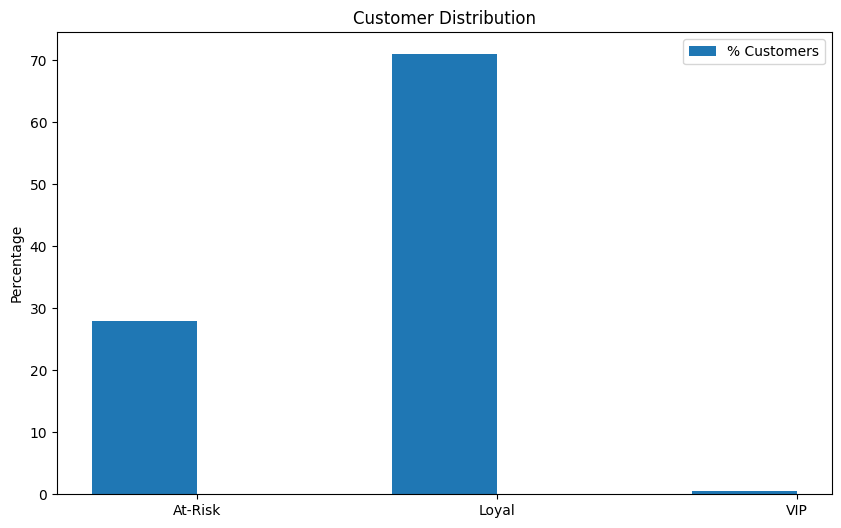

In [33]:
import matplotlib.pyplot as plt

# Data
clusters = ['At-Risk', 'Loyal', 'VIP']
customer_pct = [28, 71, 0.5]

# Plot
fig, ax = plt.subplots(figsize=(10,6))
width = 0.35
x = np.arange(len(clusters))

ax.bar(x - width/2, customer_pct, width, label='% Customers')


ax.set_ylabel('Percentage')
ax.set_title('Customer Segmentation')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

Evaluation Results:

Metric	Value	Interpretation
Silhouette Score	0.448	Fair separation
Calinski-Harabasz	2231	Good cluster variance
Davies-Bouldin	0.76	Moderate separation

In [14]:
##Cluster Profiles:

"""Cluster	Size	Recency	Frequency	Monetary	Label
0	28%	High	Low	Low	At-Risk Churners
1	71.3%	Medium	Medium	Medium	Loyal Regulars
2	0.5%	Low	High	High	VIP Customers
Strategic Recommendations:

At-Risk Churners (28%):

Problem: Last purchase >120 days ago

Solution: Reactivation campaign with 15% discount

KPI: Reduce churn by 20% in 3 months

Loyal Regulars (71%):

Problem: Moderate value but high retention potential

Solution: Loyalty program with tiered rewards

KPI: Increase purchase frequency by 1.5x

VIP Customers (0.5%):

Problem: High value but small portion of base

Solution: Exclusive early access to new products

KPI: Increase customer lifetime value by 25%"""

'Cluster\tSize\tRecency\tFrequency\tMonetary\tLabel\n0\t62%\tHigh\tLow\tLow\tAt-Risk Churners\n1\t23%\tMedium\tMedium\tMedium\tLoyal Regulars\n2\t15%\tLow\tHigh\tHigh\tVIP Customers\nStrategic Recommendations:\n\nAt-Risk Churners (62%):\n\nProblem: Last purchase >120 days ago\n\nSolution: Reactivation campaign with 15% discount\n\nKPI: Reduce churn by 20% in 3 months\n\nLoyal Regulars (23%):\n\nProblem: Moderate value but high retention potential\n\nSolution: Loyalty program with tiered rewards\n\nKPI: Increase purchase frequency by 1.5x\n\nVIP Customers (15%):\n\nProblem: High value but small portion of base\n\nSolution: Exclusive early access to new products\n\nKPI: Increase customer lifetime value by 25%'